In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.linalg import toeplitz, cholesky
import numba
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm, trange

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
plt.rcParams['figure.figsize'] = [10, 8]

In [4]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

In [5]:
all_rows = pd.option_context("display.max_rows", None)

In [6]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

In [7]:
front = pd.read_parquet("front.parquet")
shortlist = pd.read_parquet("shortlist.parquet").set_index("contract")
front = front.loc[shortlist.index]

In [8]:
front["cost"] = (
    front.close *
    shortlist.eval("cost_bps / 10_000 * multiplier").loc[front.index.get_level_values("contract")].values
)

In [9]:
shortlist

,dollar_vol,dollar_vol_per,volume,currency,exchange,exch_symbol,category,cat_rank,name,start_year,multiplier,cost_bps
contract,,,,,,,,,,,,
ES,1.046455e+10,22044.083531,474710.040651,USD,CME,ES,equities,1,e-mini S&P 500 Index-CME,1982,12.5000,6.0
US,1.644644e+09,14613.594904,112542.050566,USD,CBT,US,bonds,1,U.S. T-Bond (combined)-CBT,1977,15.6250,1.0
LGO,5.061734e+08,22976.641791,22029.913389,USD,ICE-EU,G,hard,1,Low Sulphur Gasoil (combined),1981,25.0000,10.0
CU,2.213436e+08,4067.791221,54413.706583,USD,CME,Y2,forex,1,Euro (combined)-CME,1976,6.2500,3.0
C2,6.366785e+07,971.247086,65552.678453,USD,CBT,C,soft,1,Corn (combined)-CBT,1976,12.5000,10.0
NQ,2.041016e+09,25065.018340,81428.862687,USD,CME,NQ,equities,2,e-mini Nasdaq 100 Index-CME,1996,5.0000,6.0
FV,5.638781e+08,2550.885788,221051.891481,USD,CBT,FV,bonds,2,5-Year U.S. T-Note (combined)-CBT,1988,7.8125,1.0
JY,1.027627e+08,3486.508055,29474.376320,USD,CME,JY,forex,2,Japanese Yen (combined)-CME,1976,6.2500,3.0
CL2,9.310108e+07,1226.650036,75898.651312,USD,NYMEX,CL,hard,2,Crude Oil (combined)-NYMEX,1983,10.0000,10.0


In [10]:
vol = front.eval("d_close").abs().groupby("contract").rolling(180).mean().droplevel(0)
rets = front.d_close.div(vol).dropna()
ret_stats = rets.groupby("contract").agg(["mean", "std"])
rets_z = rets.sub(ret_stats["mean"]).div(ret_stats["std"])
rets_z_wide = rets_z.unstack("contract").sort_index()

In [11]:
rets_z_wide = rets_z_wide.loc[:, ~shortlist.category.isin(["equities", "bonds"])]

In [12]:
acf = pd.Series([(rets_z_wide * rets_z_wide.shift(n)).stack().mean() for n in trange(1, 300)])

  0%|          | 0/299 [00:00<?, ?it/s]

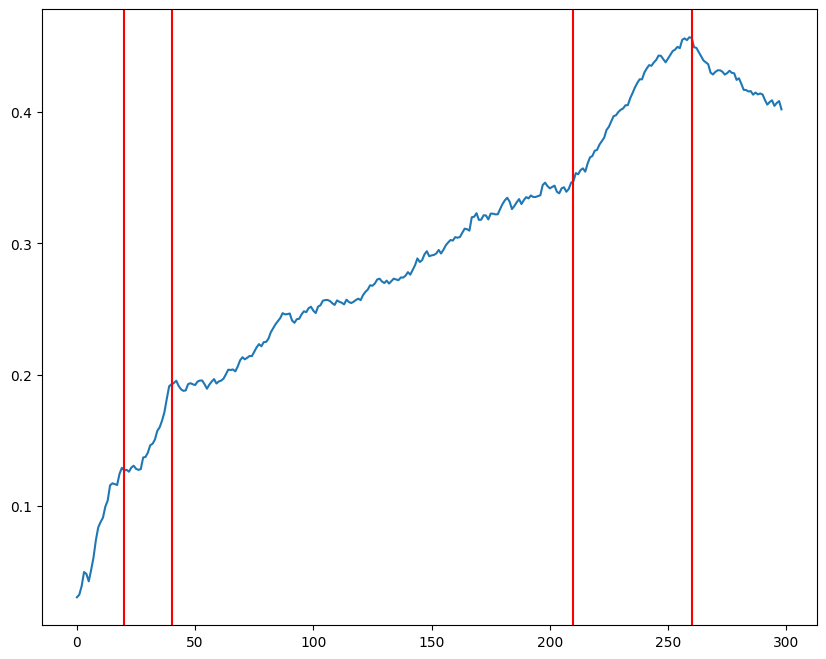

In [32]:
breakpoints = [20, 40, 210, 260]
acf.cumsum().plot()
for b in breakpoints:
    plt.axvline(b, color="red")

In [33]:
def acf_segment(i, j):
    return np.repeat(acf[i:j].mean(), j - i)

In [34]:
corr_vec = np.concatenate([np.r_[1]] + [acf_segment(i, j) for i, j in  zip([0] + breakpoints, breakpoints)])
corr_mat = toeplitz(corr_vec)
chol_mat = cholesky(corr_mat)

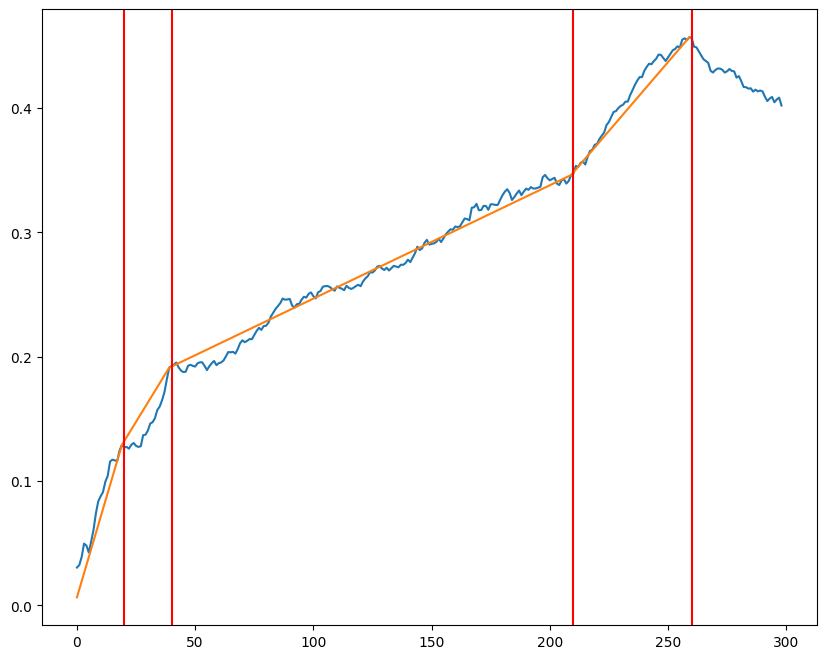

In [35]:
acf.cumsum().plot()
plt.plot(corr_vec[1:].cumsum())
for b in breakpoints:
    plt.axvline(b, color="red")

In [36]:
beta = np.linalg.inv(corr_mat[:-1, :-1]) @ corr_mat[:-1, -1]

In [37]:
epsilon = (corr_mat[-1, -1] - beta @ corr_mat[:-1, :-1] @ beta)**0.5

In [38]:
# Gross Sharpe
(beta @ corr_mat[:-1, :-1] @ beta)**0.5 * 250**0.5

0.514301531727388

In [39]:
%%time
draw = np.random.randn(10_000, corr_vec.shape[0]) @ chol_mat

CPU times: user 552 ms, sys: 485 ms, total: 1.04 s
Wall time: 129 ms


In [40]:
strat = (draw[:, :-1] @ beta) * draw[:, -1]

In [41]:
strat.mean() / strat.std() * 250**0.5

0.4767733708776088

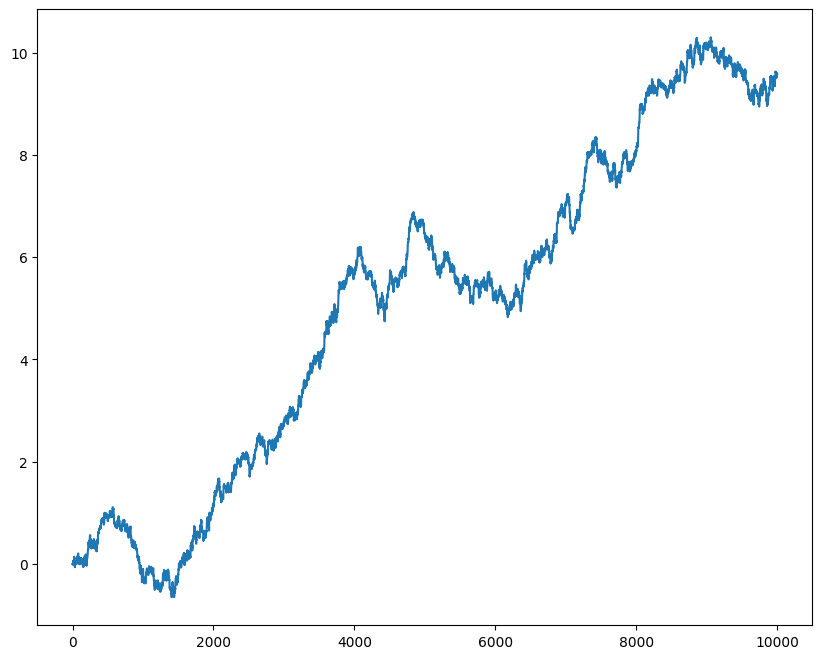

In [42]:
plt.plot(strat.cumsum())

In [43]:
%%time
draw = np.random.randn(100_000, corr_vec.shape[0]) @ chol_mat

CPU times: user 2.29 s, sys: 415 ms, total: 2.71 s
Wall time: 946 ms


# Plot some gross returns

/tmp/ipykernel_6637/2305543366.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


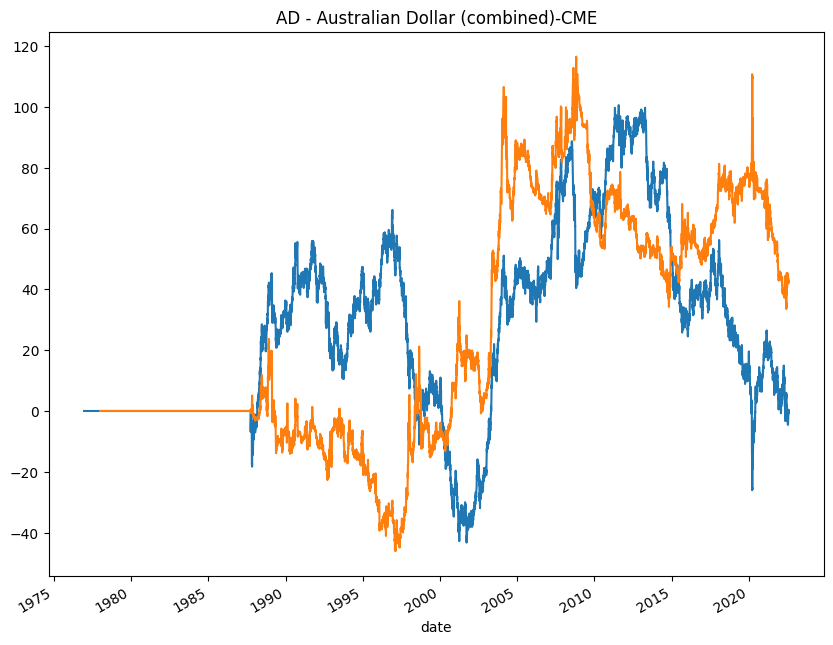

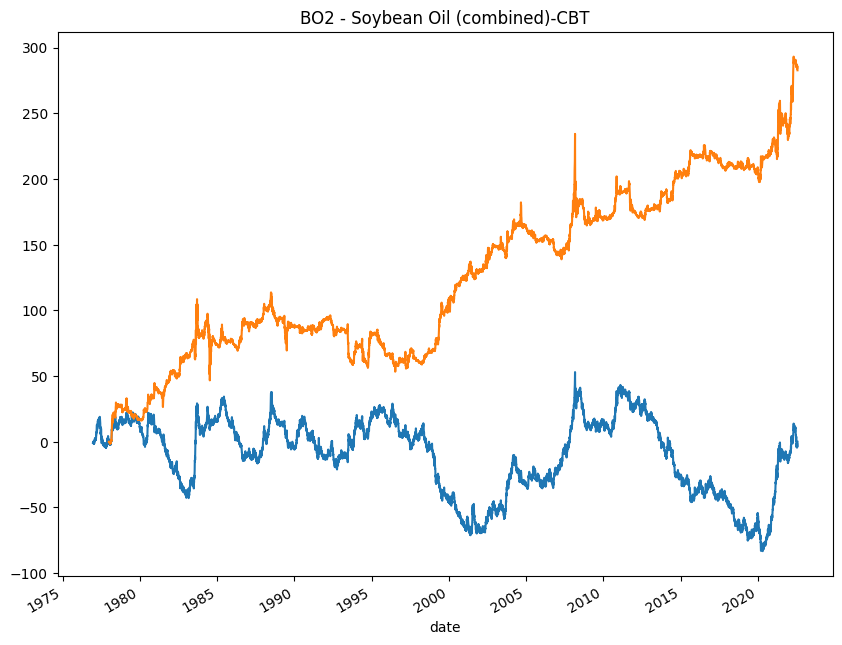

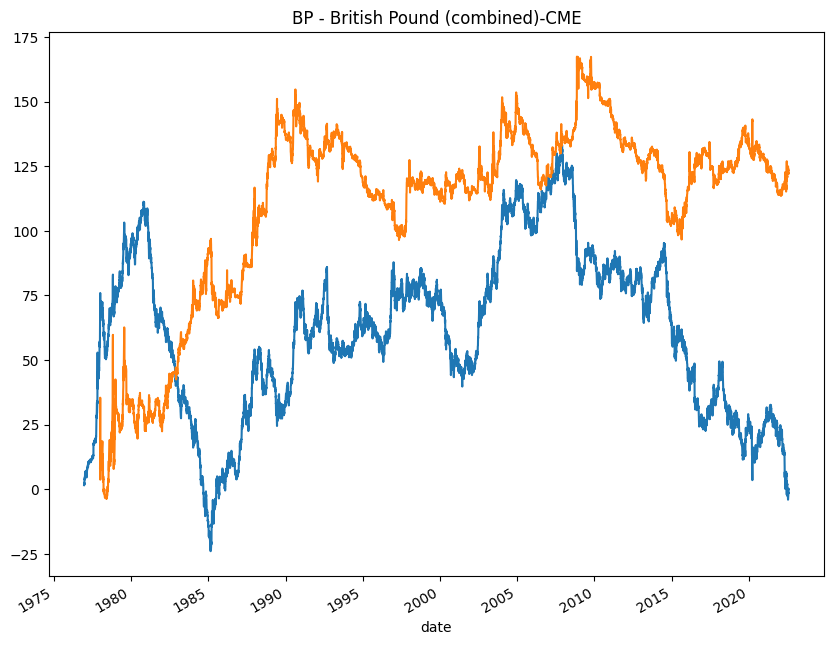

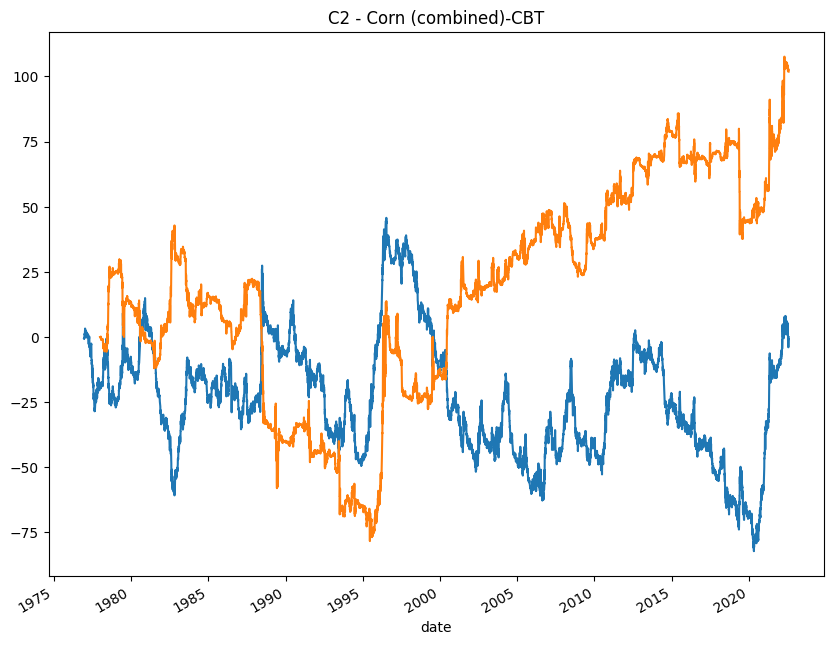

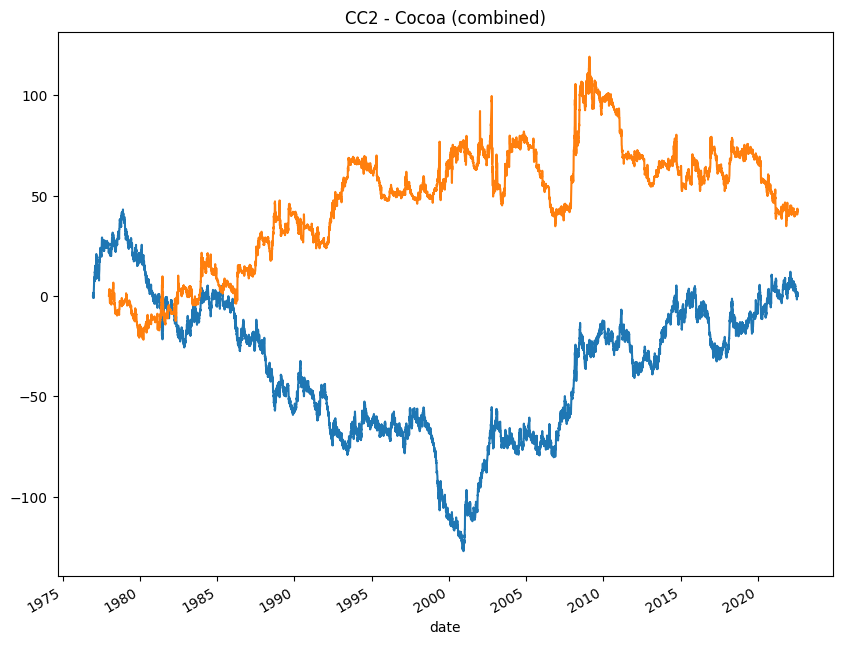

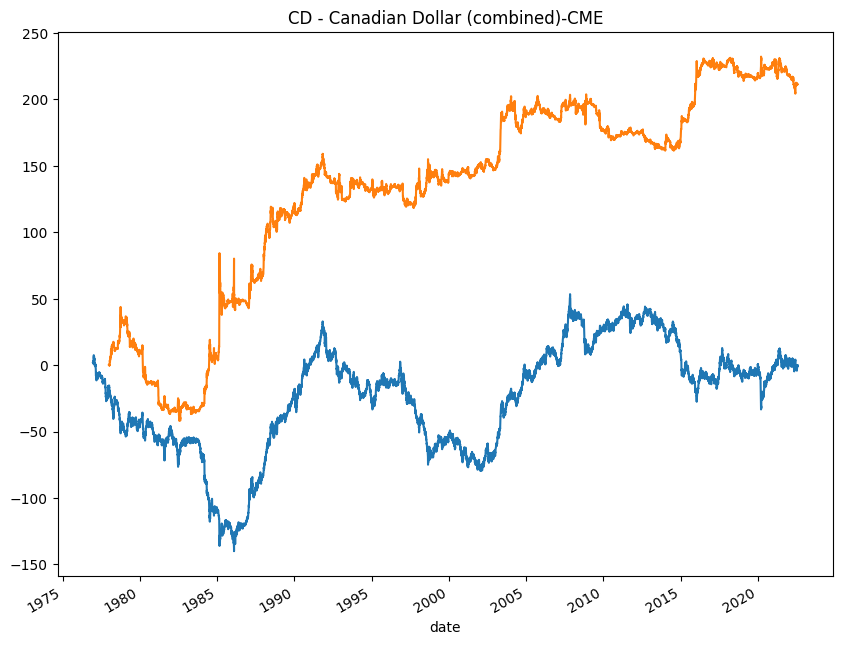

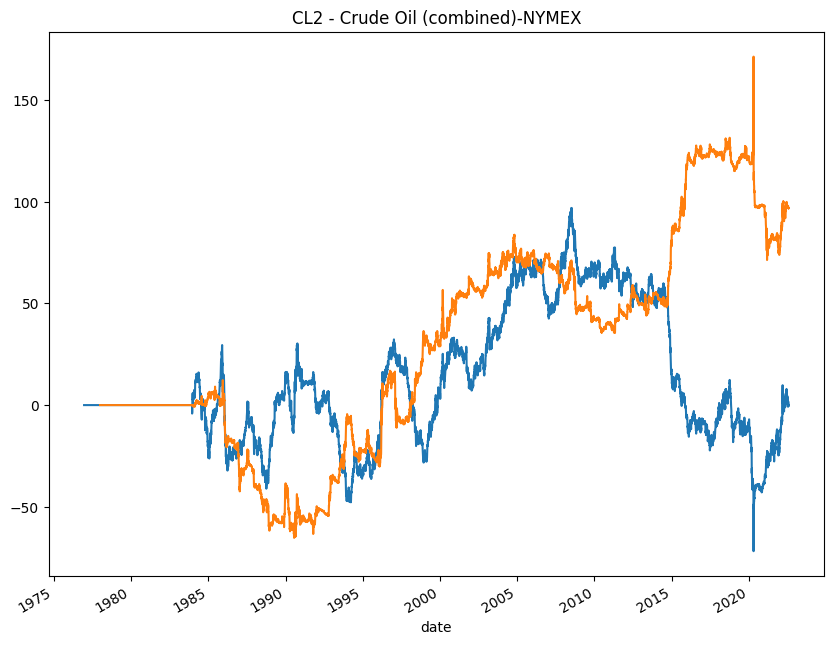

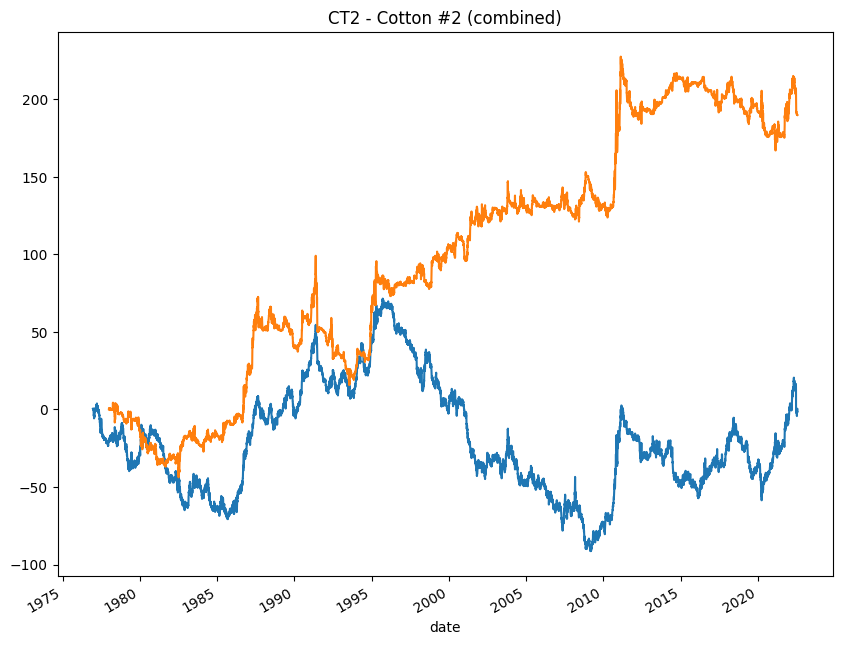

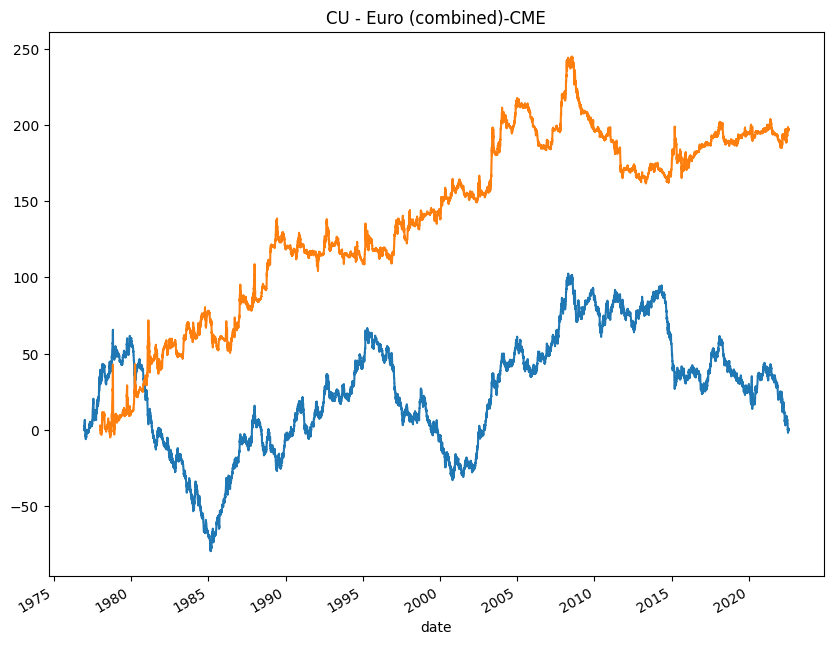

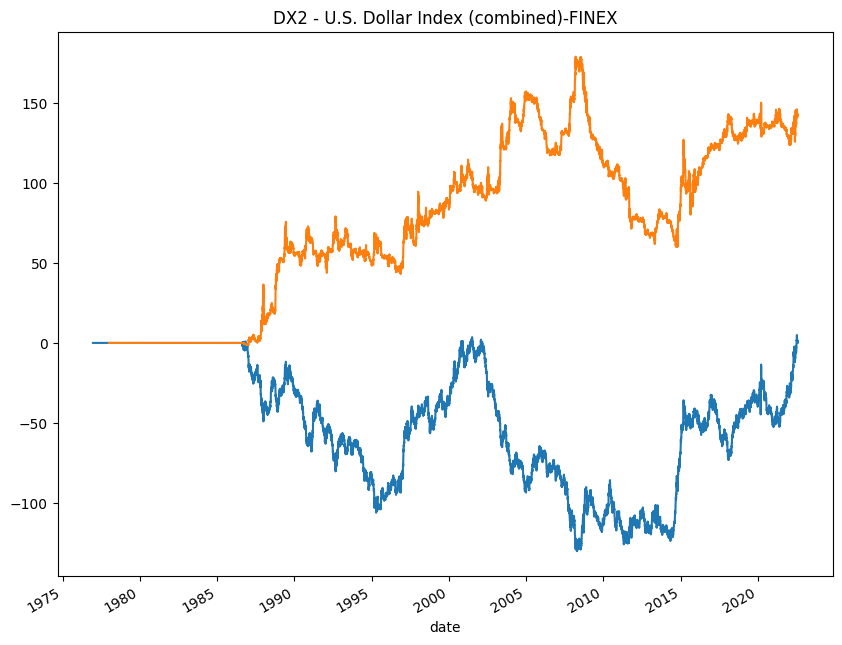

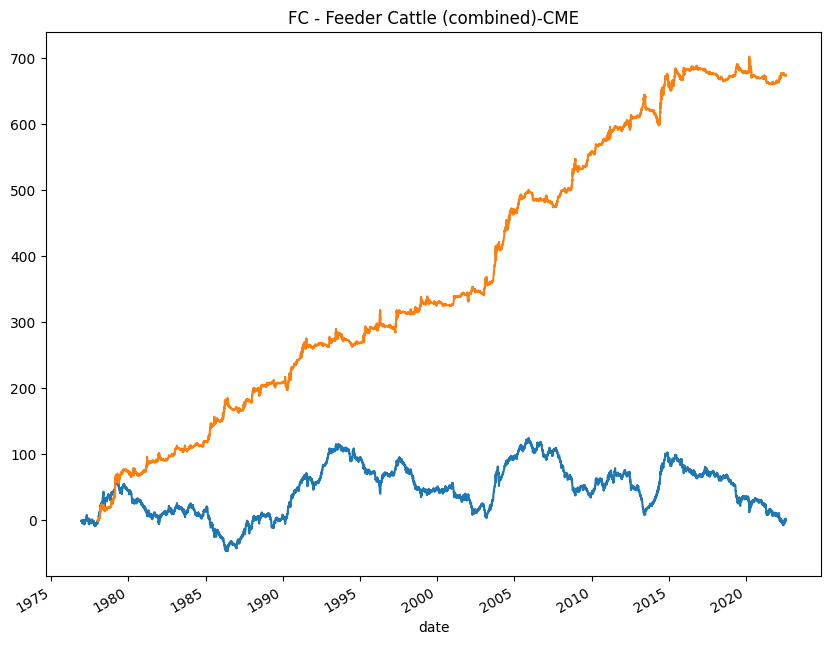

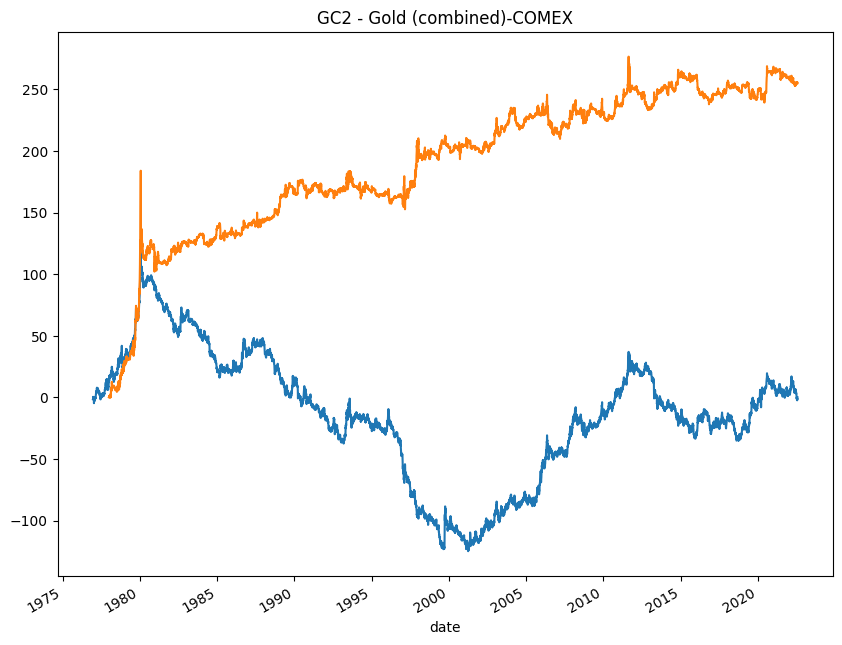

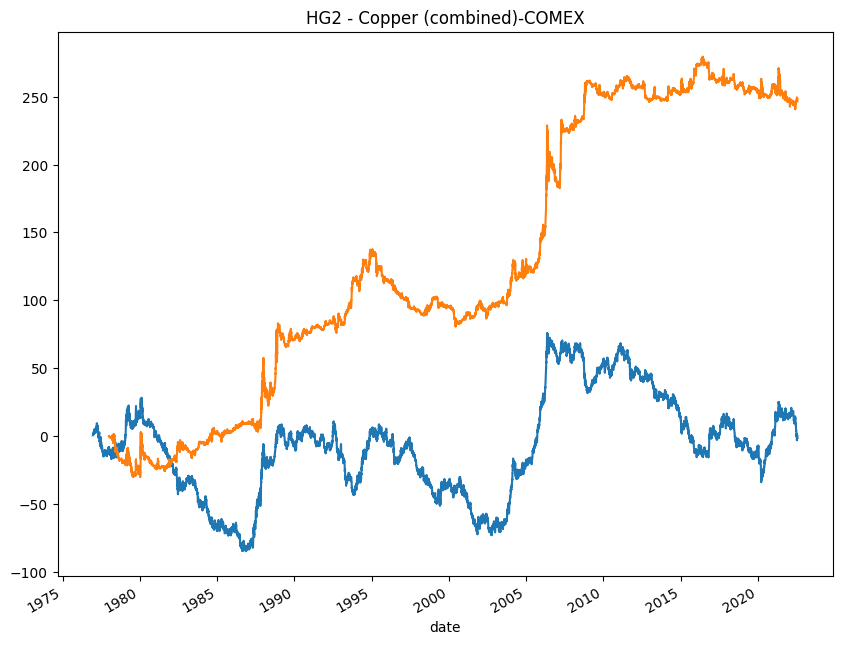

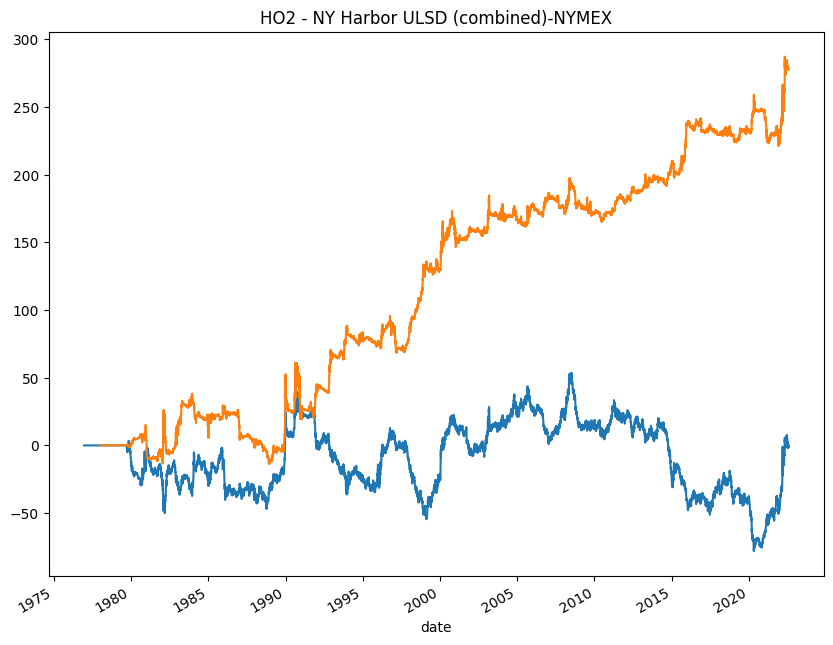

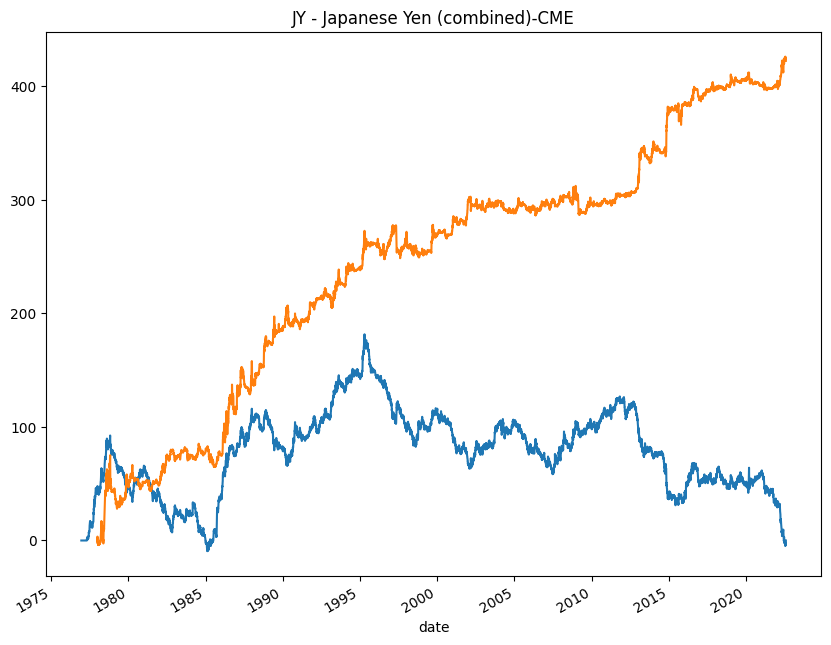

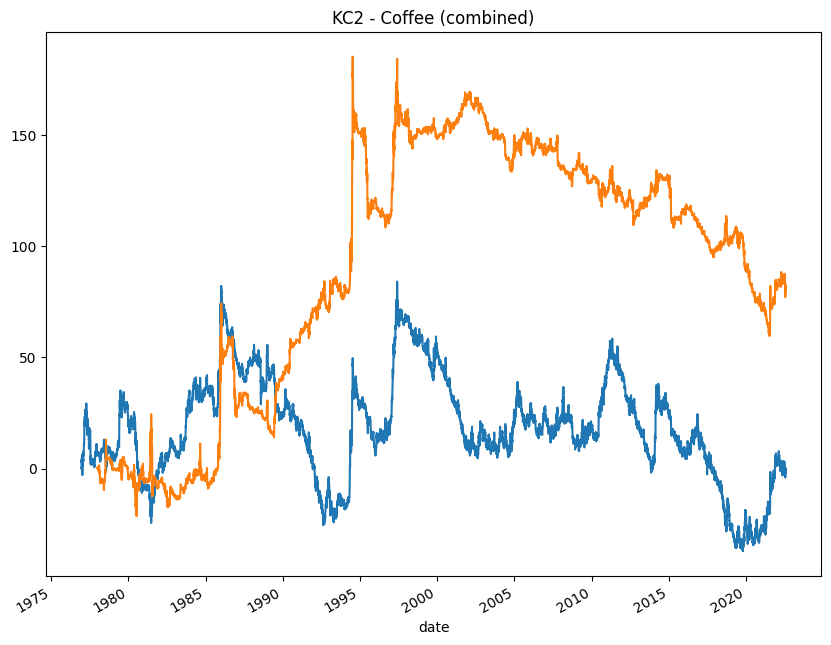

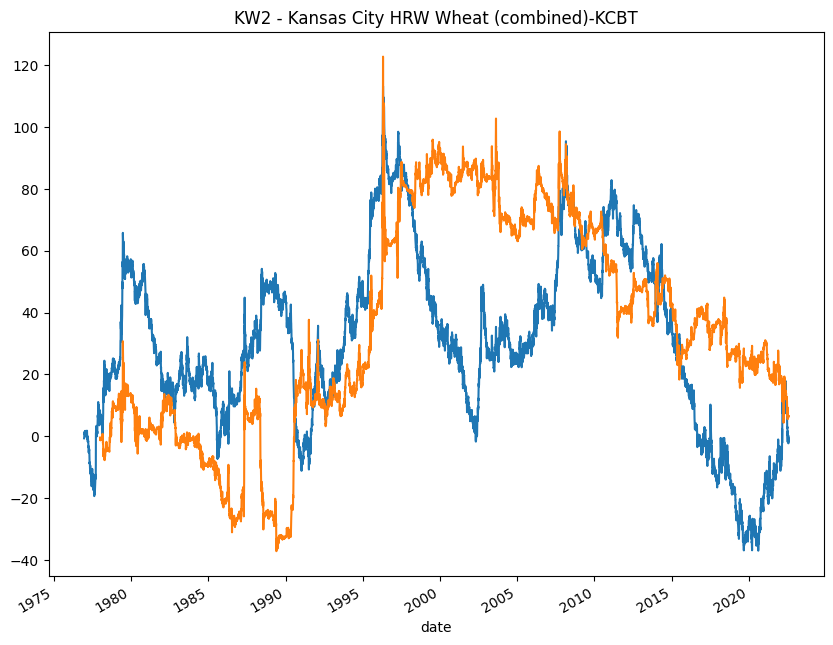

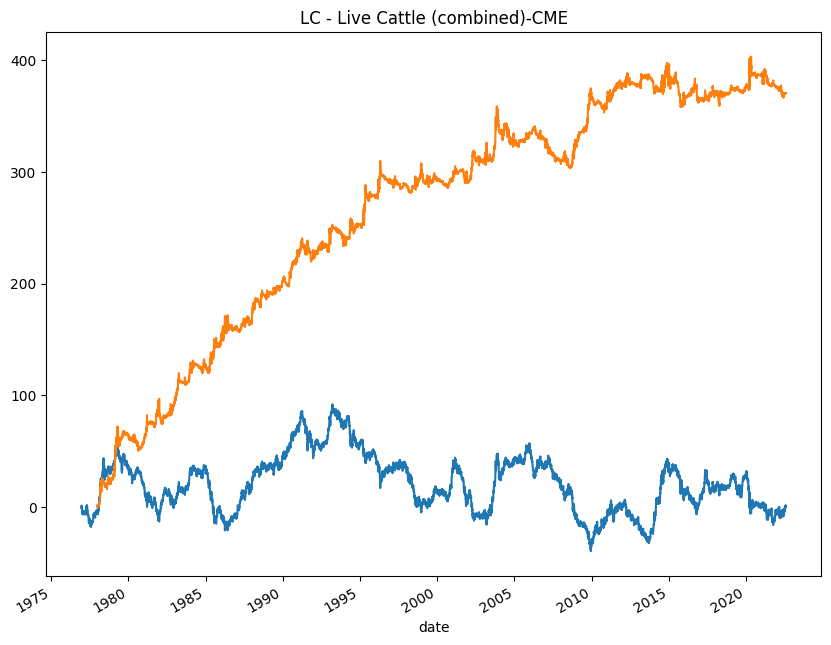

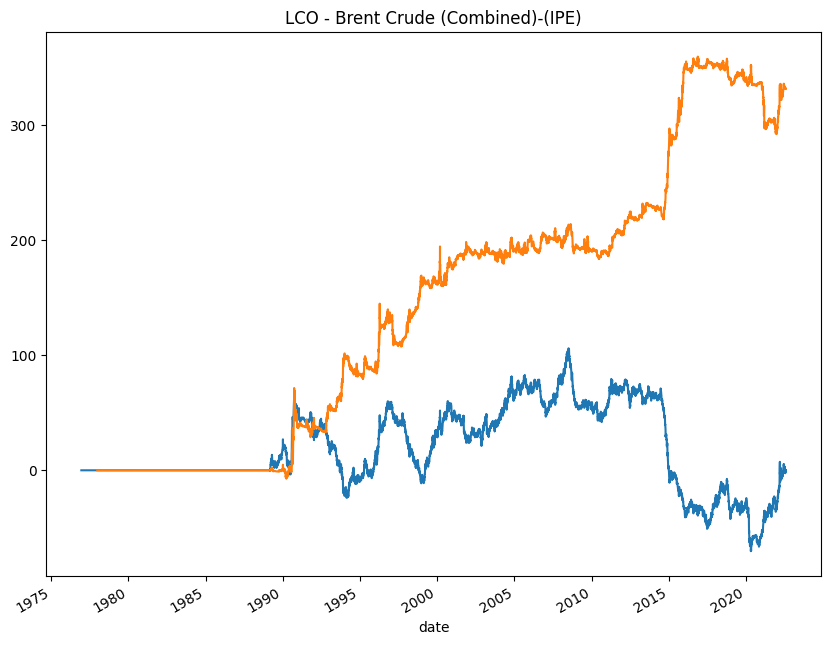

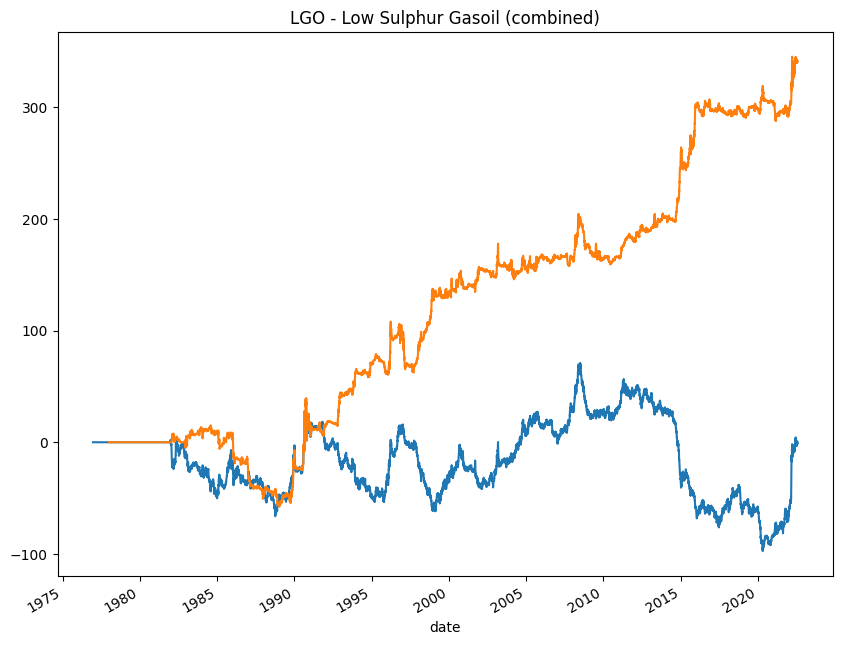

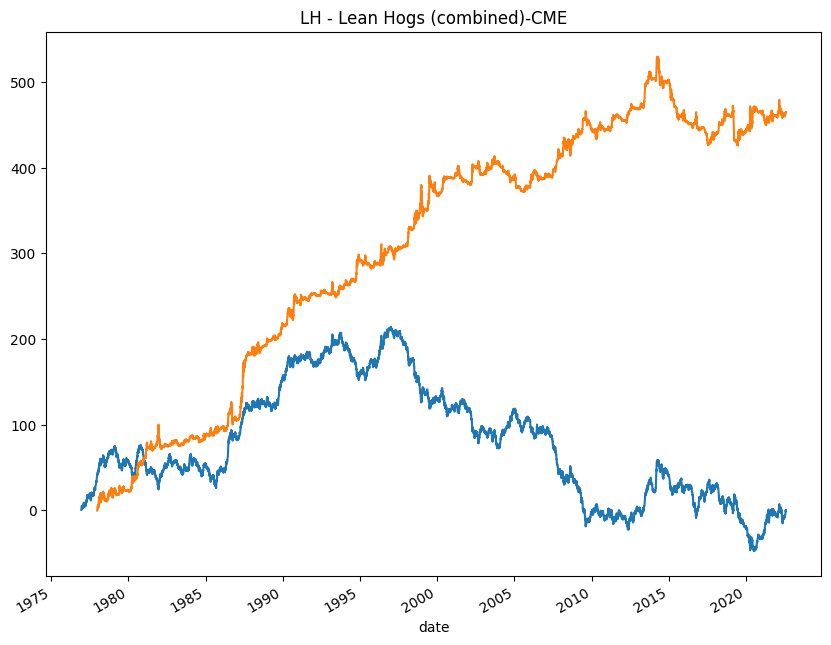

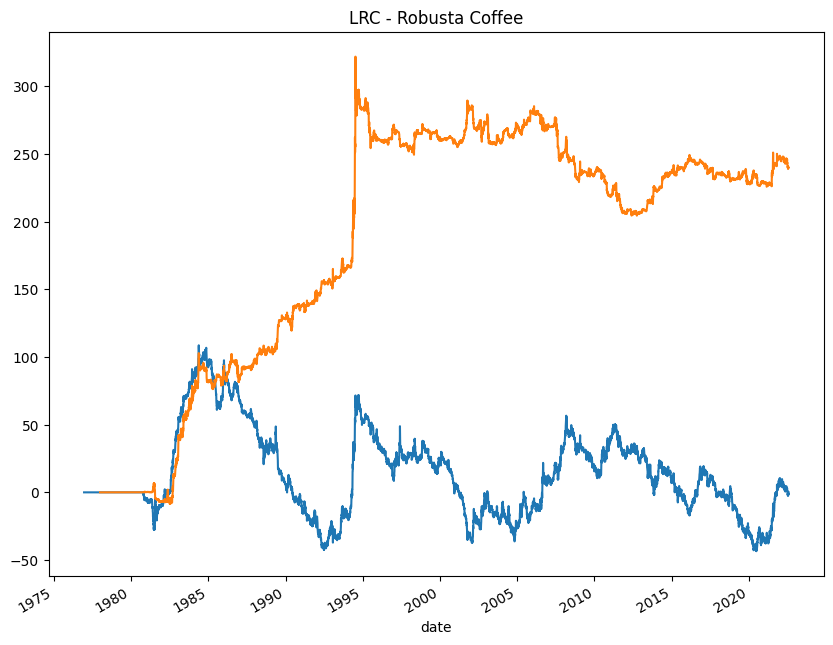

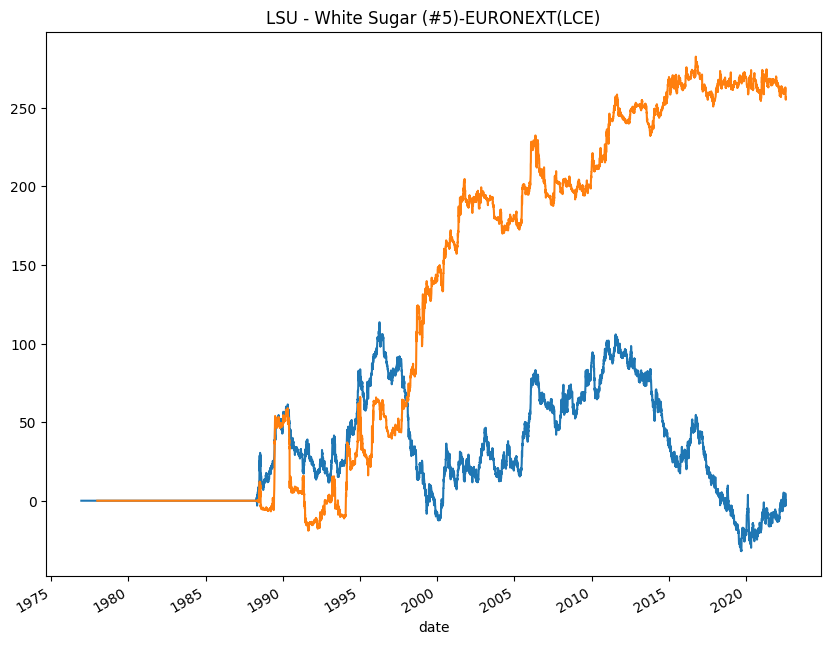

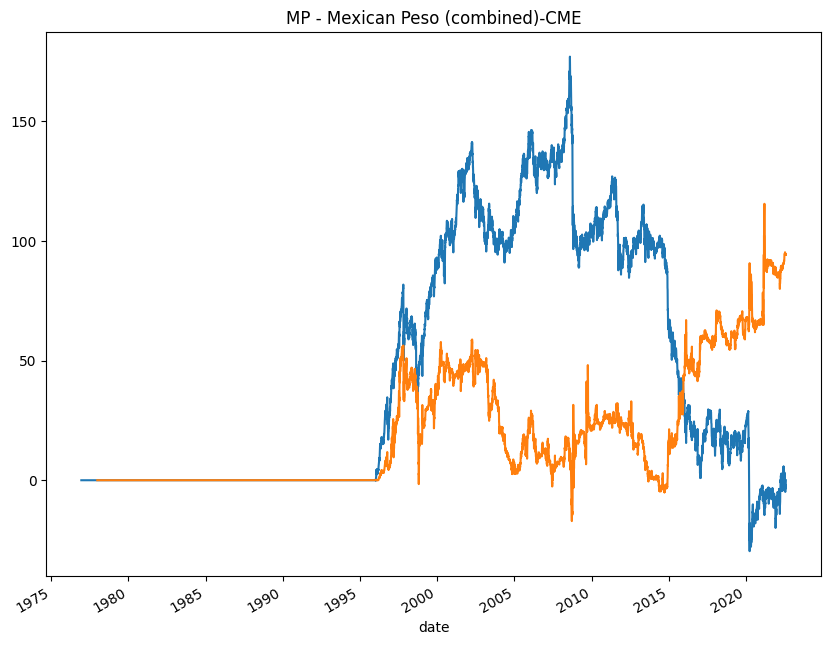

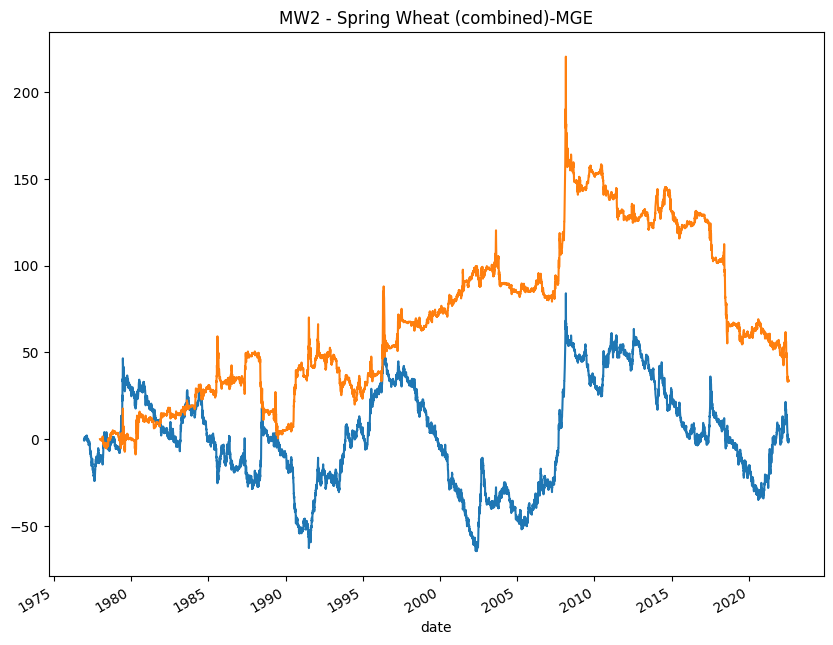

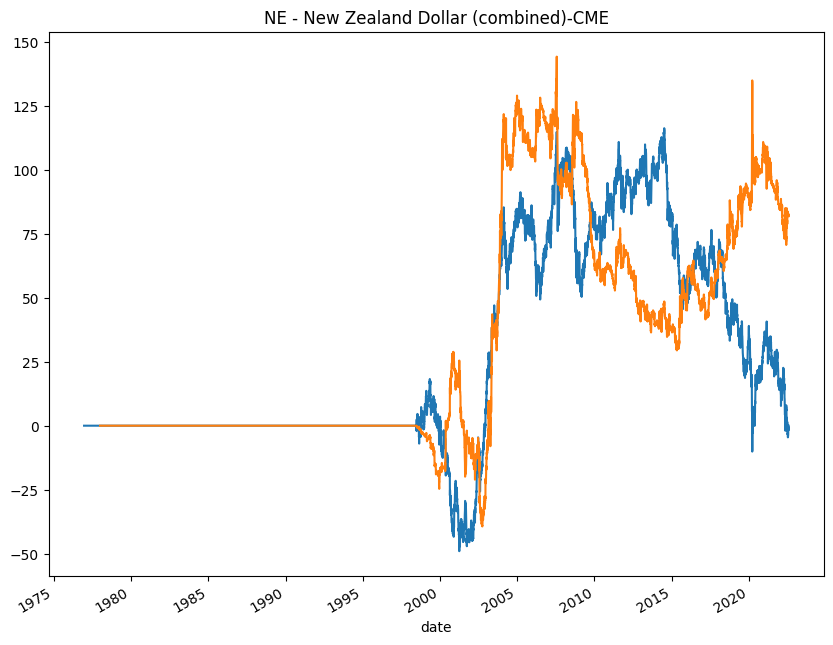

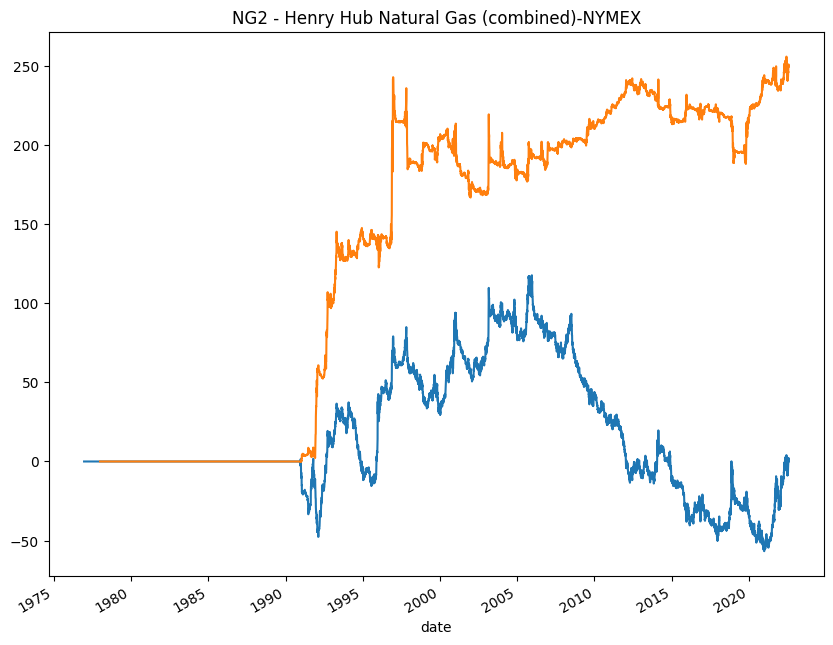

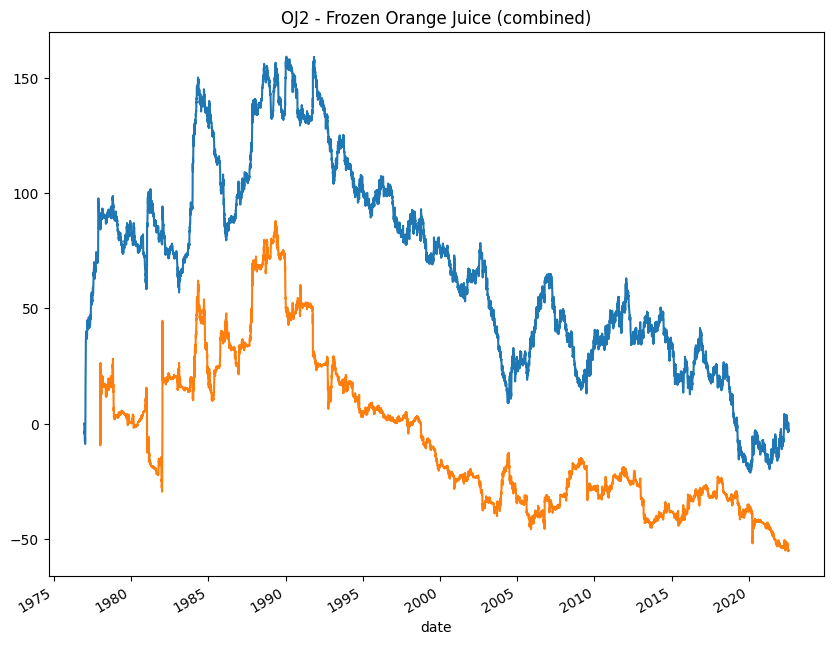

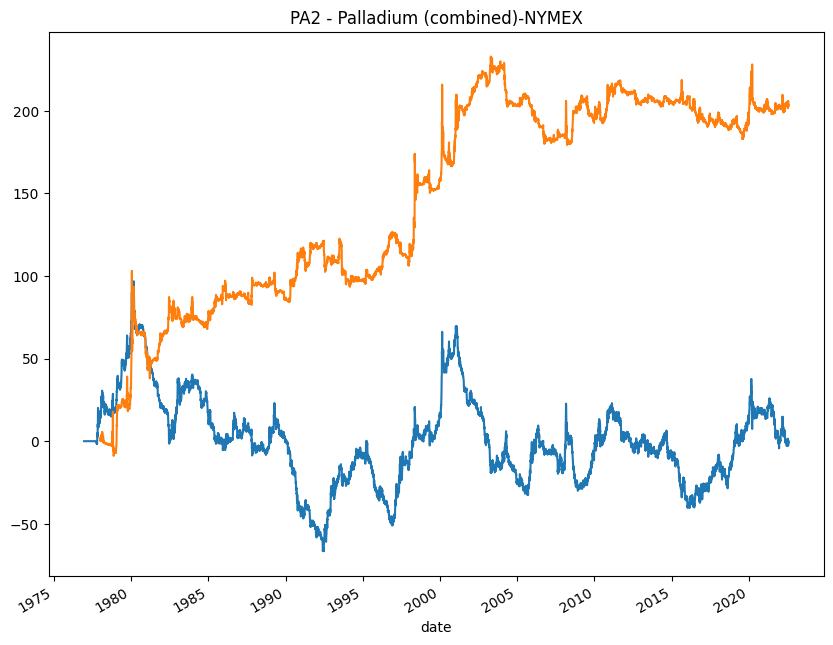

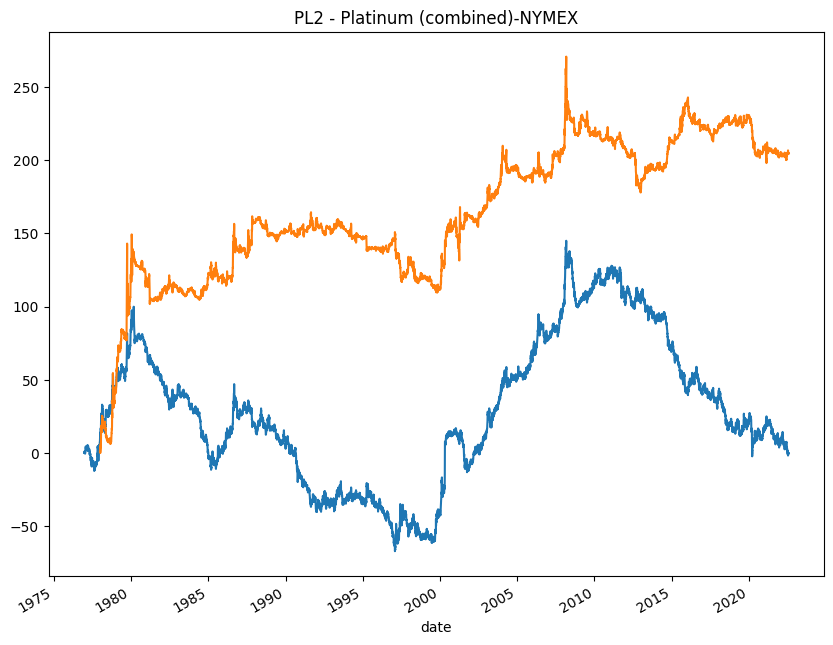

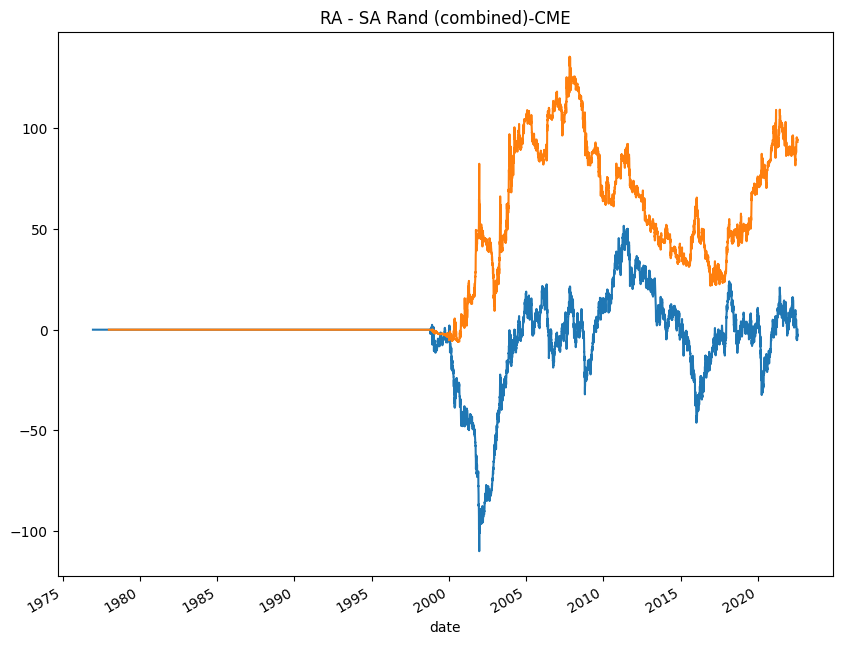

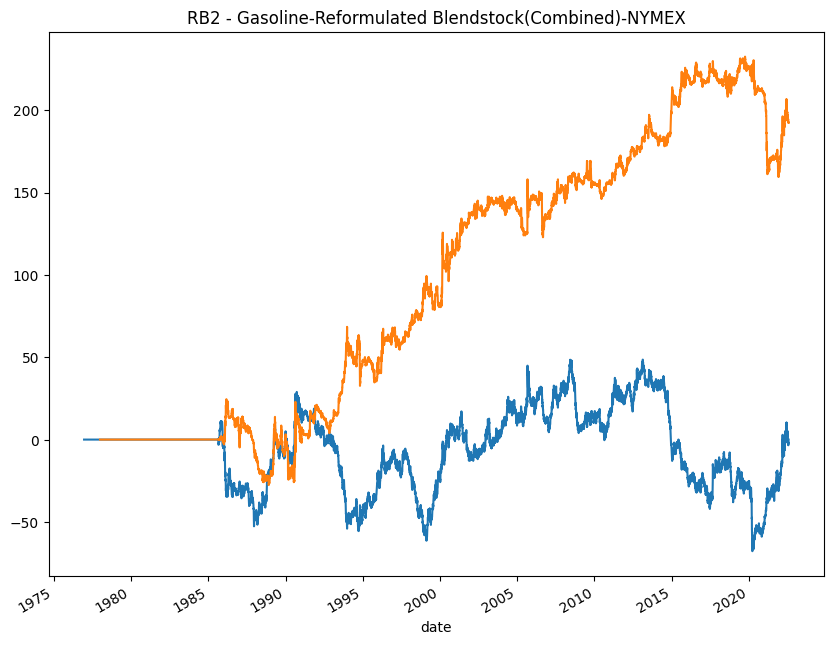

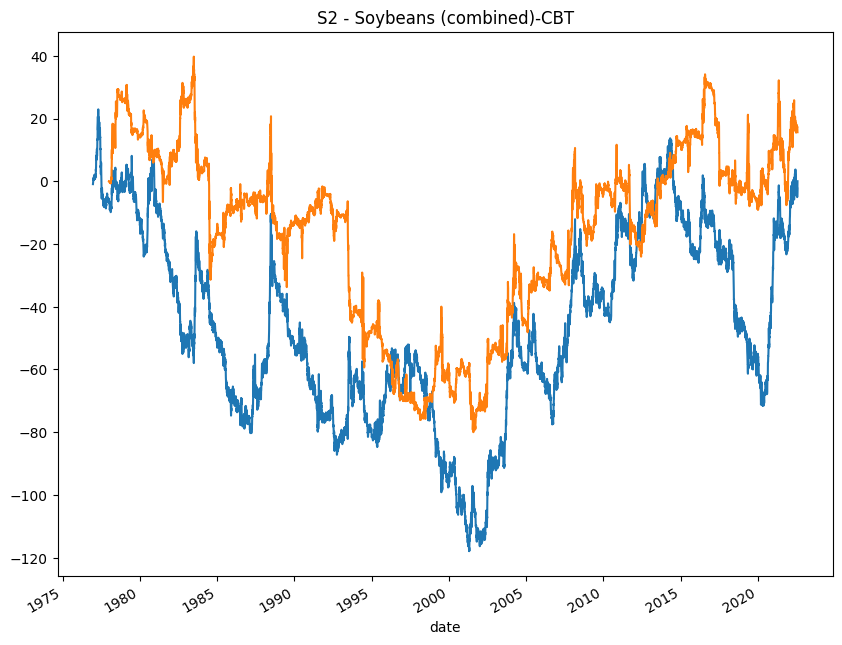

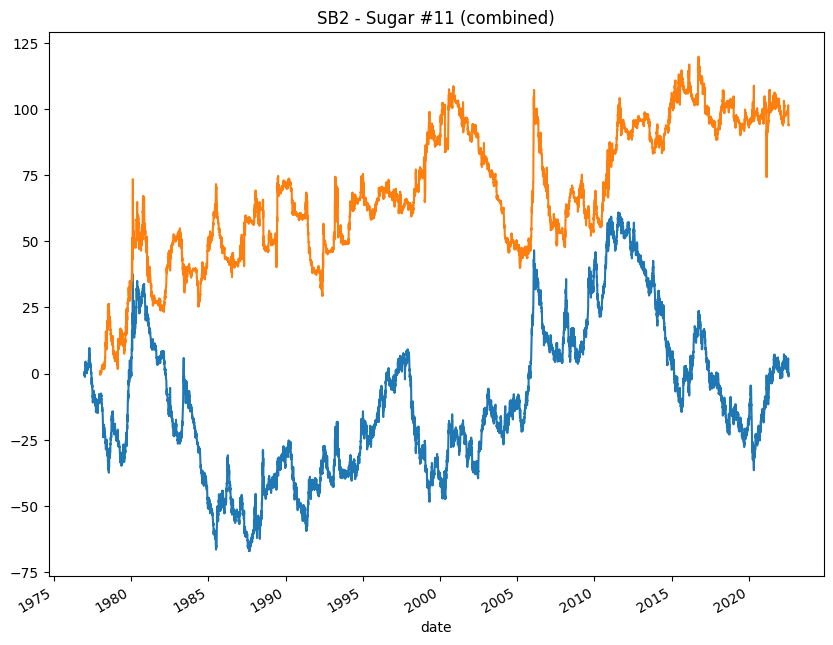

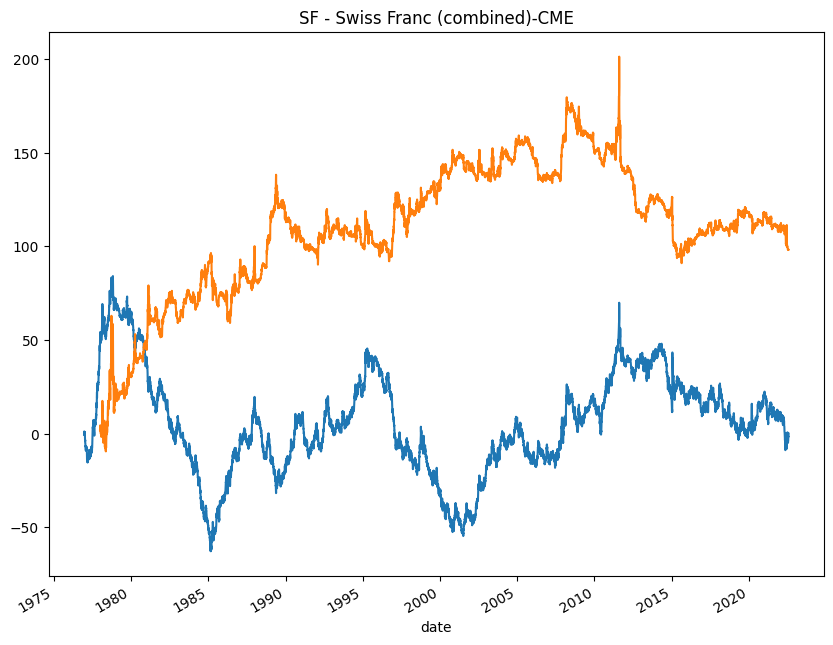

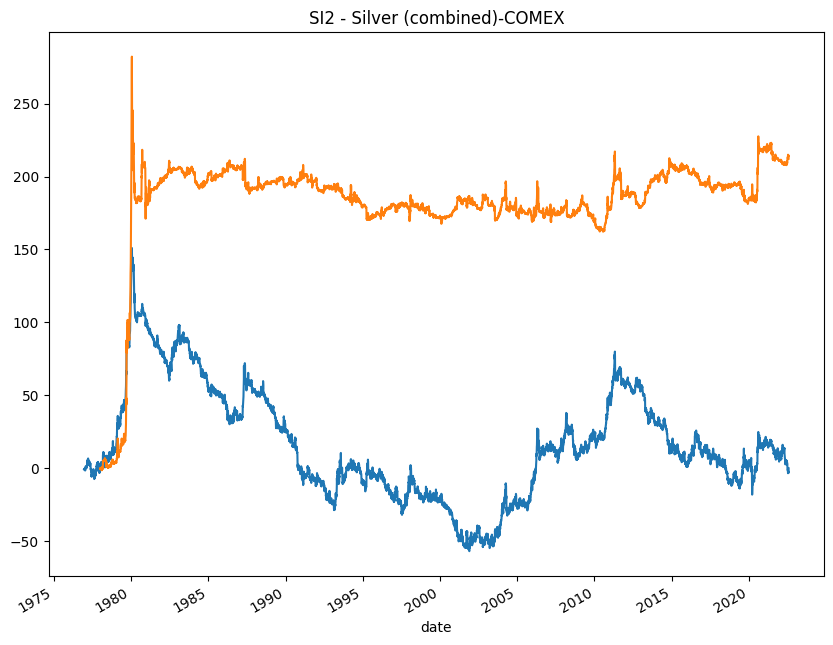

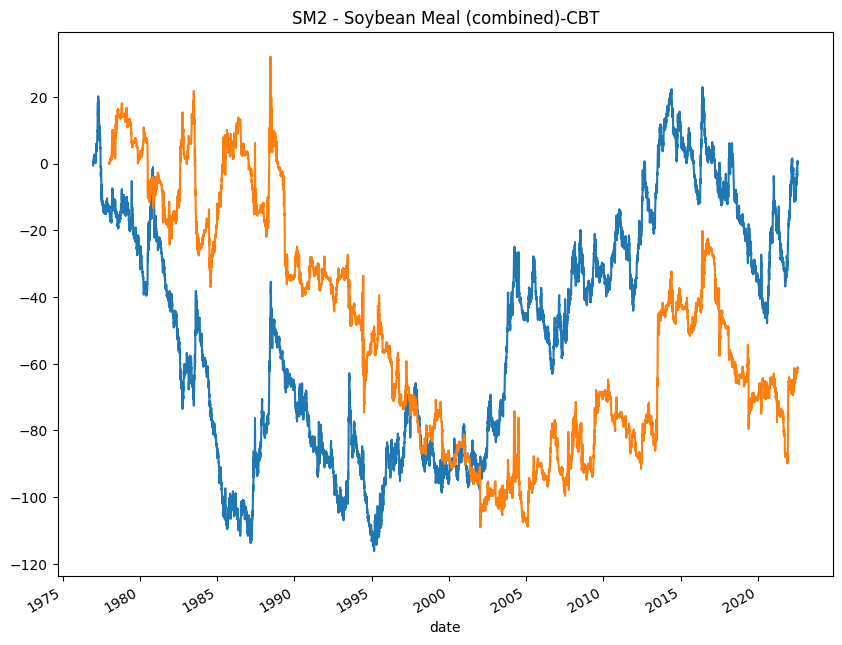

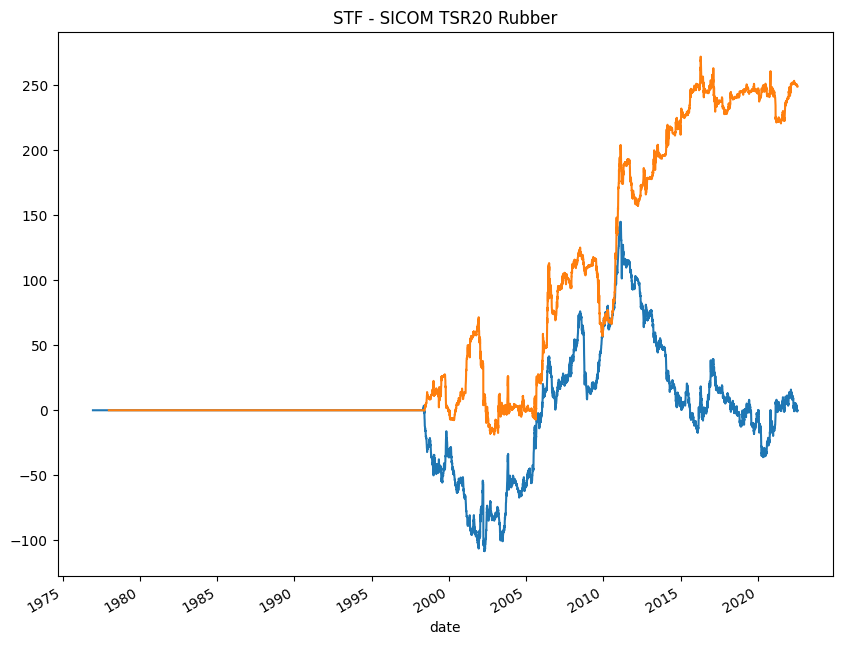

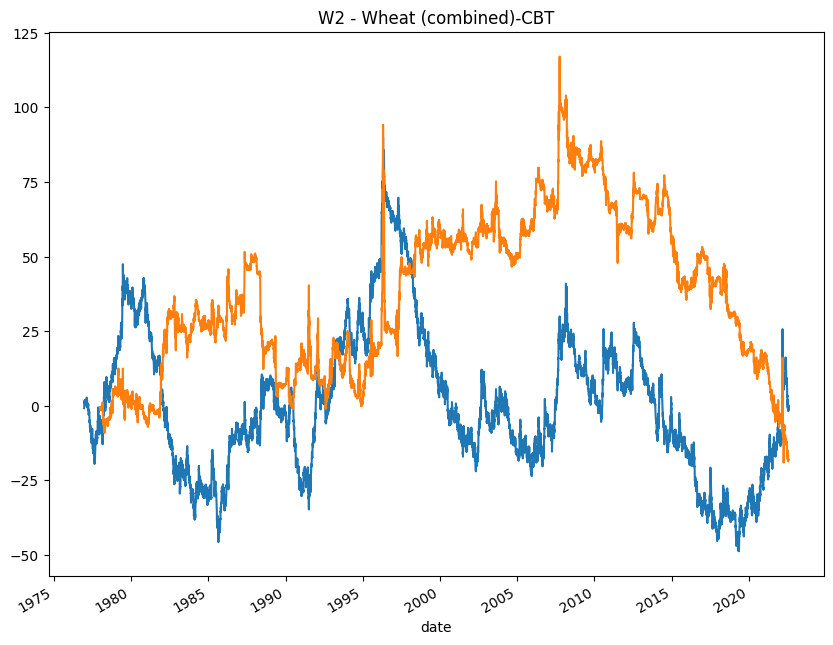

In [44]:
strat_ix = rets_z_wide.index[len(beta):]

strats = []
for contract0 in rets_z_wide.columns:
    base = rets_z_wide[contract0].fillna(0)
    strat = (np.convolve(base, beta, mode="valid")[:-1] + base.mean()) * (base[strat_ix] - base.mean())
    base /= base.std()
    strat /= strat.std()
    strats.append(strat)
    plt.figure()
    ax = base.cumsum().plot(title=f"{contract0} - {shortlist.name[contract0]}")
    strat.dropna().cumsum().plot(ax=ax)

<AxesSubplot: xlabel='date'>

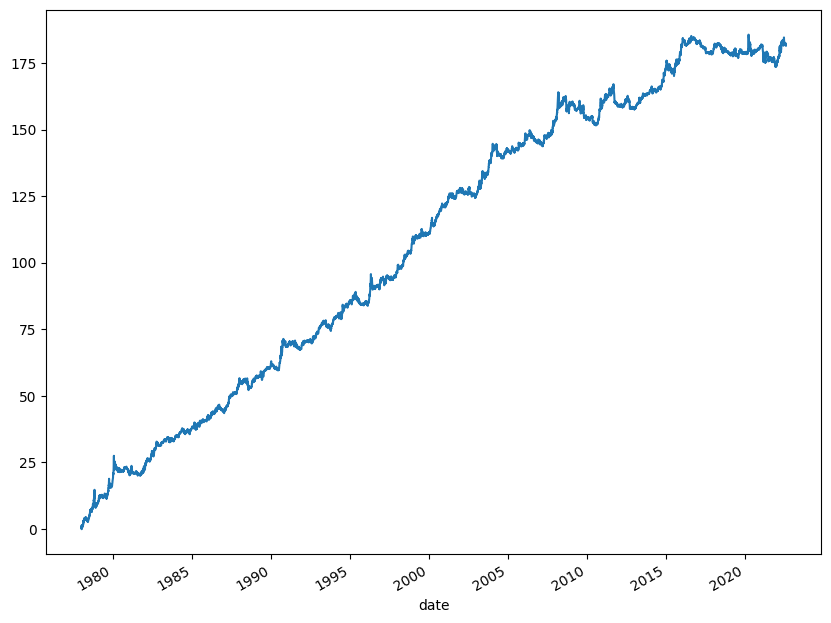

In [45]:
strats_mu = pd.concat(strats, axis=1).mean(1)
strats_mu.cumsum().plot()

<AxesSubplot: title={'center': 'Gross Sharpe'}, xlabel='date'>

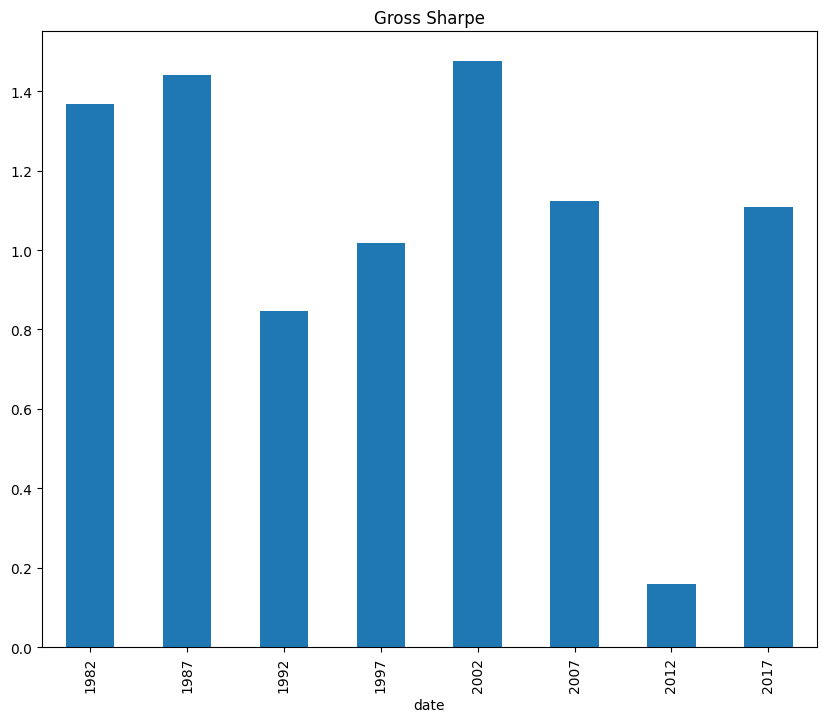

In [53]:
(
    strats_mu.groupby(pd.Grouper(freq="5Y")).apply(lambda xs: xs.mean() / xs.std() * 250**0.5)
    .rename(lambda xs: xs.year).iloc[1:-1]
    .plot.bar(title="Gross Sharpe")
)